# Wine quality dataset - model training pipeline

In [63]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import numpy as np
import os

## Load feature group, create feature view and create train/validation/test split

In [4]:
import hopsworks
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/185497
Connected. Call `.close()` to terminate connection gracefully.


In [5]:
wine_quality_fg = fs.get_feature_group("wine_quality", version=1)
query = wine_quality_fg.select_all()

In [6]:
feature_view = fs.get_or_create_feature_view("wine_quality",
                                             version=1,
                                             description="Read from wine quality dataset",
                                             labels=["quality"],
                                             query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/185497/fs/185416/fv/wine_quality/version/1


For some unknown reason, the dataset from the feature view is smaller than the dataset from the original csv-files by over 1000 samples. The reason for this is unknown and I cannot find a solution.

In [7]:
get_split = True
if get_split:
    X_train, X_val, X_test, Y_train, Y_val, Y_test = feature_view.get_train_validation_test_split(
                                                        training_dataset_version=1)
    
else:
    description = "Train/val/test split with subset of features"
    X_train, X_val, X_test, Y_train, Y_val, Y_test = feature_view.train_validation_test_split(
                                                validation_size=0.15,
                                                test_size=0.15,
                                                description=description)

print(X_train.shape, X_val.shape, X_test.shape)

Finished: Reading data from Hopsworks, using ArrowFlight (1.63s) 
(3722, 11) (797, 11) (799, 11)


## Model Creation

Due to the nature of the target label, one could interpret it as both a classification or a regression problem. Classification will be tried here. The target label is most likely a subjective score on a scale from 1-10, but extreme values either missing or very few (no score of 1, 2 or 10 and only 5 samples with a score of 9). This could make the classification difficult.

A robust scaler is used to scale the data to avoid numerical features that span over large values to dominate. Robust scaler is supposedly better at handling outliers, as it uses the median and interquartile range instead of mean and standard deviation.

In [9]:
robust_scaler = RobustScaler().fit(X_train)

X_train_scaled = robust_scaler.transform(X_train)
X_val_scaled = robust_scaler.transform(X_val)
X_test_scaled = robust_scaler.transform(X_test)

Different classifiers are created and fitted to the training set and performance compared on the validation set.

In [56]:
# A usual starting point to find optimal k in kNN is sqrt(# samples in train data)
sqrt_n = int(np.sqrt(X_train.shape[0]))

k_neighbours = np.linspace(1, sqrt_n+20, sqrt_n+20, dtype=np.int32)
knns = []
knn_val_accuracies = []
for k in k_neighbours:
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train_scaled, np.ravel(Y_train))
    knns.append(knn)
    knn_val_preds = knn.predict(X_val_scaled)
    knn_val_accuracies.append(accuracy_score(np.ravel(Y_val), knn_val_preds))

best_knn_idx = np.argmax(knn_val_accuracies)
best_knn = knns[best_knn_idx]
print(f"# of neighbours with highest validation accuracy: {k_neighbours[best_knn_idx]}")


# of neighbours with highest validation accuracy: 36


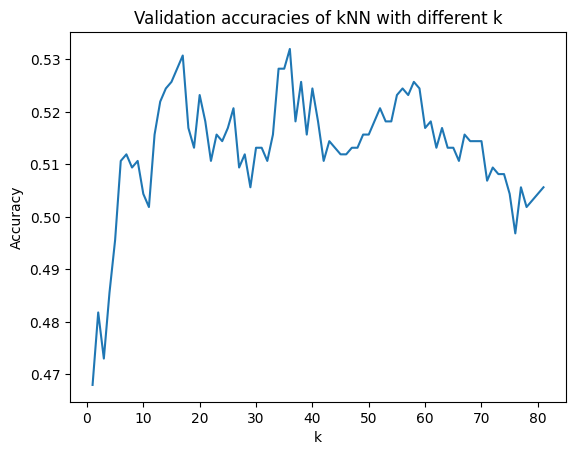

In [57]:
plt.plot(k_neighbours, knn_val_accuracies)
plt.title("Validation accuracies of kNN with different k")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()

In [58]:
GB_classifier = GradientBoostingClassifier(n_estimators=500)
SVM = SVC()
RF_classifier = RandomForestClassifier(n_estimators=200)

fitted_GB = GB_classifier.fit(X_train_scaled, np.ravel(Y_train))
fitted_SVM = SVM.fit(X_train_scaled, np.ravel(Y_train))
fitted_RF = RF_classifier.fit(X_train_scaled, np.ravel(Y_train))

In [59]:
val_pred_GB = fitted_GB.predict(X_val_scaled)
val_pred_SVM = fitted_SVM.predict(X_val_scaled)
val_pred_RF = fitted_RF.predict(X_val_scaled)

val_acc_GB = accuracy_score(Y_val, val_pred_GB)
val_acc_SVM = accuracy_score(Y_val, val_pred_SVM)
val_acc_RF = accuracy_score(Y_val, val_pred_RF)

print(f"GB validation accuracy: {val_acc_GB}")
print(f"SVM validation accuracy: {val_acc_SVM}")
print(f"RF validation accuracy: {val_acc_RF}")
print(f"kNN validation accuracy: {knn_val_accuracies[best_knn_idx]}")

GB validation accuracy: 0.5457967377666249
SVM validation accuracy: 0.5307402760351317
RF validation accuracy: 0.5658720200752823
kNN validation accuracy: 0.5319949811794228


Random forest performs the best and is the model we select.

In [60]:
test_pred_RF = fitted_RF.predict(X_test_scaled)
test_acc_RF = accuracy_score(Y_test, test_pred_RF)

print(f"Test accuracy: {test_acc_RF}")

Test accuracy: 0.5819774718397998


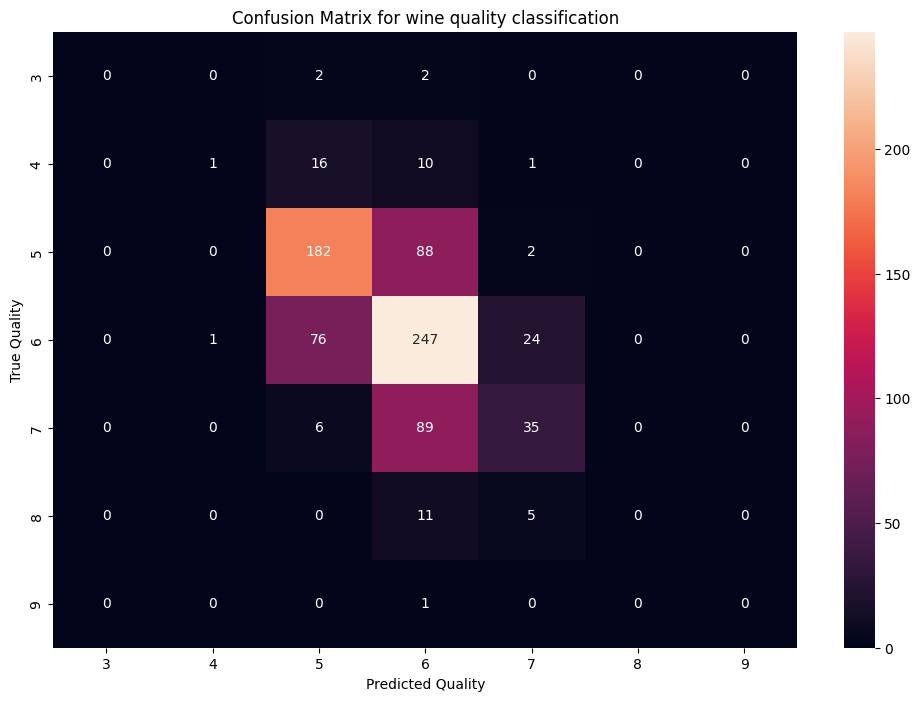

In [61]:
cm = confusion_matrix(Y_test, test_pred_RF, labels=[3, 4, 5, 6, 7, 8, 9])

hm_ax = sns.heatmap(cm, fmt=".0f", annot=True)
hm_ax.set_xticklabels(np.linspace(3, 9, 7, dtype=np.int8))
hm_ax.set_yticklabels(np.linspace(3, 9, 7, dtype=np.int8))
hm_ax.set_title("Confusion Matrix for wine quality classification")
hm_ax.set_xlabel("Predicted Quality")
hm_ax.set_ylabel("True Quality")
hm_ax.figure.set_size_inches(12, 8)

cm_fig = hm_ax.get_figure()

## Save model and scaler to model registry

In [62]:
# We will now upload our model and scaler to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the model and scaler directory will be saved to the model registry. Create the dir, first.
model_dir="wine_quality_model"
scaler_dir = "wine_quality_scaler"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)
if os.path.isdir(scaler_dir) == False:
    os.mkdir(scaler_dir)

# Save our robust scaler, model and the confusion matrix to 'model_dir' and 'scaler_dir', 
# whose contents will be uploaded to the model registry
joblib.dump(fitted_RF, model_dir + "/wine_quality_model.pkl")
joblib.dump(robust_scaler, scaler_dir + "/wine_quality_scaler.pkl")
cm_fig.savefig(model_dir + "/wine_quality_confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(Y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_quality_model = mr.python.create_model(
    name="wine_quality_model", 
    metrics={"accuracy" : test_acc_RF},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)
wine_quality_scaler = mr.python.create_model(
    name="wine_quality_scaler",
    model_schema=model_schema,
    description="Trained robust scaler for wine quality model"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_quality_model.save(model_dir)
wine_quality_scaler.save(scaler_dir)

Connected. Call `.close()` to terminate connection gracefully.


Model export complete: 100%|██████████| 6/6 [01:30<00:00, 15.11s/it]                   


Model created, explore it at https://c.app.hopsworks.ai:443/p/185497/models/wine_quality_model/1


Model export complete: 100%|██████████| 6/6 [01:40<00:00, 16.71s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/185497/models/wine_quality_scaler/1


Model(name: 'wine_quality_scaler', version: 1)